In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

###############################################
# Data Reading and Preprocessing
###############################################
stock_symbol = "AAL"
start_date = "2015-01-01"
end_date = "2025-01-01"

# Download Yahoo Finance data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, auto_adjust=False)
stock_data.reset_index(inplace=True)
stock_data.set_index('Date', inplace=True)
columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adj Close']
data_to_normalize = stock_data[columns_to_normalize].values
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)
mean_tensor = tensor_data.mean(dim=0)
std_tensor = tensor_data.std(dim=0)
normalized_data = (tensor_data - mean_tensor) / std_tensor

df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)
df_normalized['Date'] = stock_data.index
data = df_normalized

train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

train_data = data.iloc[:train_size]
val_data   = data.iloc[train_size:train_size + val_size]
test_data  = data.iloc[train_size + val_size:]

feature_columns = ['Low', 'Open', 'High']
target_column   = 'Close'

train_features = train_data[feature_columns].values   
train_target   = train_data[target_column].values        

val_features   = val_data[feature_columns].values
val_target     = val_data[target_column].values

test_features  = test_data[feature_columns].values
test_target    = test_data[target_column].values

train_features = torch.tensor(train_features, dtype=torch.float32)
train_target   = torch.tensor(train_target, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
val_target     = torch.tensor(val_target, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)
test_target    = torch.tensor(test_target, dtype=torch.float32)

[*********************100%***********************]  1 of 1 completed


In [13]:
###############################################
# Define GCN Layer
###############################################
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x, A):
        x = torch.matmul(A, x)
        x = self.linear(x)
        return torch.relu(x)

###############################################
# Define Model Combining GCN and LSTM
###############################################
class LSTM_GCN_Model(nn.Module):
    def __init__(self, input_size, gcn_out_features, lstm_hidden_size, output_size, num_layers, A_norm):
        super(LSTM_GCN_Model, self).__init__()
        self.gcn = GCNLayer(in_features=1, out_features=gcn_out_features)
        self.lstm = nn.LSTM(gcn_out_features, lstm_hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        self.register_buffer('A_norm', A_norm)
        self.num_nodes = input_size

    def forward(self, x):
        x = x.squeeze(1)
        x = x.unsqueeze(-1)
        x = self.gcn(x, self.A_norm)
        x = x.mean(dim=1)
        x = x.unsqueeze(1)
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

###############################################
# Define Model Training Parameters and Precompute Adjacency Matrix
###############################################
num_epochs = 100
input_size = len(feature_columns)  # 3
output_size = 1
learning_rate = 0.001

gcn_out_features = 16      # Output dimension of GCN layer, adjustable as needed
lstm_hidden_size = 64      # LSTM hidden layer dimension
num_layers = 2             # Number of LSTM layers

# Define a fully connected adjacency matrix for the 3 nodes and normalize it
num_nodes = input_size
A = torch.ones(num_nodes, num_nodes)  # Fully connected (including self-loops)
degree = A.sum(dim=1)
D_inv_sqrt = torch.diag(torch.pow(degree, -0.5))
A_norm = D_inv_sqrt @ A @ D_inv_sqrt  # (3, 3)

###############################################
# Build Model, Define Loss and Optimizer
###############################################
model = LSTM_GCN_Model(input_size, gcn_out_features, lstm_hidden_size, output_size, num_layers, A_norm)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Used to record losses at each stage
train_losses = []
val_losses   = []
test_losses  = []

###############################################
# Model Training Loop
###############################################
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
A_norm = A_norm.to(device)
model.to(device)

# Move data to GPU if available
train_features = train_features.to(device)
train_target = train_target.to(device)
val_features = val_features.to(device)
val_target = val_target.to(device)
test_features = test_features.to(device)
test_target = test_target.to(device)


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features.unsqueeze(1))
    loss = criterion(outputs, train_target.unsqueeze(1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features.unsqueeze(1))
        val_loss = criterion(val_outputs, val_target.unsqueeze(1))
    val_losses.append(val_loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')
    
    # Testing
    with torch.no_grad():
        test_outputs = model(test_features.unsqueeze(1))
        test_loss = criterion(test_outputs, test_target.unsqueeze(1))
    test_losses.append(test_loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')


Epoch [1/100], Training Loss: 0.9524
Epoch [1/100], Validation Loss: 0.9524
Epoch [1/100], Test Loss: 1.2212
Epoch [2/100], Training Loss: 0.9403
Epoch [2/100], Validation Loss: 0.9627
Epoch [2/100], Test Loss: 1.2324
Epoch [3/100], Training Loss: 0.9281
Epoch [3/100], Validation Loss: 0.9731
Epoch [3/100], Test Loss: 1.2437
Epoch [4/100], Training Loss: 0.9159
Epoch [4/100], Validation Loss: 0.9836
Epoch [4/100], Test Loss: 1.2550
Epoch [5/100], Training Loss: 0.9034
Epoch [5/100], Validation Loss: 0.9942
Epoch [5/100], Test Loss: 1.2665
Epoch [6/100], Training Loss: 0.8906
Epoch [6/100], Validation Loss: 1.0049
Epoch [6/100], Test Loss: 1.2780
Epoch [7/100], Training Loss: 0.8774
Epoch [7/100], Validation Loss: 1.0158
Epoch [7/100], Test Loss: 1.2898
Epoch [8/100], Training Loss: 0.8636
Epoch [8/100], Validation Loss: 1.0270
Epoch [8/100], Test Loss: 1.3017
Epoch [9/100], Training Loss: 0.8494
Epoch [9/100], Validation Loss: 1.0383
Epoch [9/100], Test Loss: 1.3138
Epoch [10/100], Tra

Validation Set Metrics (LSTM + GCN):
Mean Absolute Error (MAE): 0.1650
Mean Squared Error (MSE): 0.0320
Root Mean Squared Error (RMSE): 0.1789
Mean Absolute Percentage Error (MAPE): 16.8766

Test Set Metrics (LSTM + GCN):
Mean Absolute Error (MAE): 0.2248
Mean Squared Error (MSE): 0.0554
Root Mean Squared Error (RMSE): 0.2354
Mean Absolute Percentage Error (MAPE): 20.5783


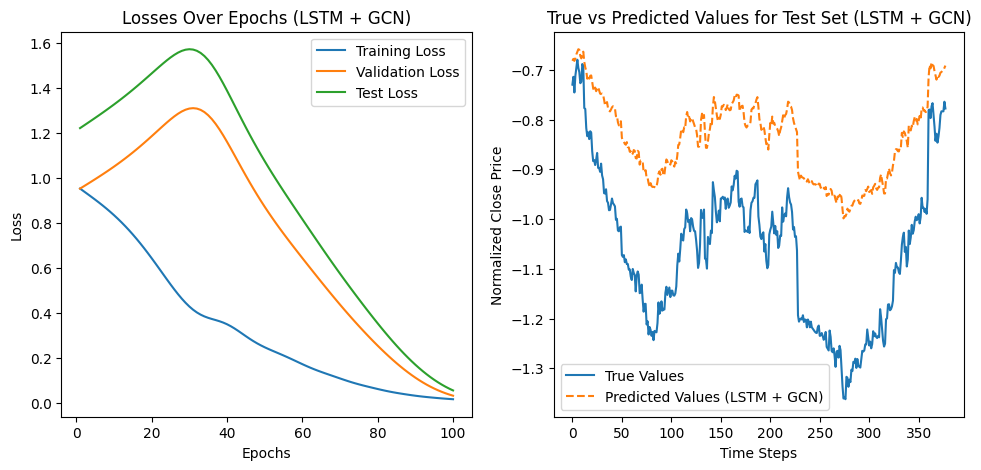

In [17]:
###############################################
# Model Evaluation: Validation and Test Sets
###############################################
model.eval()
with torch.no_grad():
    val_predictions = model(val_features.unsqueeze(1))
val_predictions = val_predictions.squeeze(1).cpu().numpy()

mae_val = mean_absolute_error(val_target.cpu().numpy(), val_predictions)
mse_val = mean_squared_error(val_target.cpu().numpy(), val_predictions)
rmse_val = np.sqrt(mse_val)
mape_val = calculate_mape(val_target.cpu().numpy(), val_predictions)

print('Validation Set Metrics (LSTM + GCN):')
print(f'Mean Absolute Error (MAE): {mae_val:.4f}')
print(f'Mean Squared Error (MSE): {mse_val:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val:.4f}\n')

with torch.no_grad():
    test_predictions = model(test_features.unsqueeze(1))
test_predictions = test_predictions.squeeze(1).cpu().numpy()

mae_test = mean_absolute_error(test_target.cpu().numpy(), test_predictions)
mse_test = mean_squared_error(test_target.cpu().numpy(), test_predictions)
rmse_test = np.sqrt(mse_test)
mape_test = calculate_mape(test_target.cpu().numpy(), test_predictions)

print('Test Set Metrics (LSTM + GCN):')
print(f'Mean Absolute Error (MAE): {mae_test:.4f}')
print(f'Mean Squared Error (MSE): {mse_test:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses Over Epochs (LSTM + GCN)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_target.cpu().numpy(), label='True Values')
plt.plot(test_predictions, label='Predicted Values (LSTM + GCN)', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set (LSTM + GCN)')
plt.legend()
plt.show()